In [1]:
#=========================================================================
# AS4012 / AS5522 Nebulae and Stars II 2020                              #
# Visualisation of EZ-Web output                                         #
#                                                                        #
# this version uses python 3                                             #
#=========================================================================

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from pylab import *
import matplotlib.pylab as plt
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.linewidth']  = 1.3
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.major.size'] = plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = plt.rcParams['ytick.minor.size'] = 4

In [3]:
#============ nature constants (global) ==============
cl      = 2.99792458E+08     # speed of light [m/s]
hplanck = 6.62607554E-34     # Planck's constant [J s]
bk      = 1.38065812E-23     # Boltzmann's constant [J/K]
elad    = 1.60217662E-19     # electron charge [C]
grav    = 6.67259850E-11     # gravitational constant [N m2/kg2]
sig_sb  = 5.67036700E-08     # Stefan Boltzmann constant [W/m2/K4]
me      = 9.10938300E-31     # electron mass [kg] 
mH      = 1.67353280E-27     # mass of hydrogen [kg] 
eV      = elad               # 1 eV in J
pi      = np.pi              # just pi
Ang     = 1.E-10             # 1 Angstroem [m]
nm      = 1.E-9              # 1 nanometer [m]
AU      = 1.49597870E+11     # 1 AU [m]
Rsun    = 6.95990000E+08     # solar radius [m]
Msun    = 1.98892250E+30     # solar mass [kg]
Lsun    = 3.84600000E+26     # solar luminosity [W]
yr      = 365.25*24.*60.*60.
a_sb    = sig_sb*4.0/cl

In [4]:
#=========== simplified material properties ===========

#=== mean molecular weight [in units of mH] ===
def mu(X,Y):
  return 4.0/(6.0*X + Y + 2.0)

#=== equation of state ===
def rho(P,T,X,Y):
  return P*mu(X,Y)*mH/(bk*T)

#=== bound-free opacity ===
def kappa_bf(P,T,X,Y):
  Z  = 1.0 - X - Y
  c1 = 1.85776232  
  c2 = 0.3396116  
  c3 = -2.38950921  
  c4 = 3.34729929  
  c5 = 6.61111851
  return c1*(Z/0.02)*(1.0+X)*(rho(P,T,X,Y)/1.E+4)**c2*(T/2.E+6)**c3 \
          *(1.0+c4*np.exp(-(T/10**c5)**2))

#=== free-free opacity ===
def kappa_ff(P,T,X,Y):
  return 4.0E+18*(X+Y)*(1+X)*rho(P,T,X,Y)*T**(-3.52)

#=== electron scattering opacity ===
def kappa_es(X):
  return 0.02*(1.0+X)

#=== total opacity ===
def kappa(P,T,X,Y):
  return kappa_bf(P,T,X,Y) + kappa_ff(P,T,X,Y) + kappa_es(X) 

#=== energy production via p-p-chain ===
def eps_pp(P,T,X,Y):
  c1 = 3.28637058e-03   
  c2 = 1.15744717e+00   
  c3 = 4.39985572e+00
  return c1*X*(rho(P,T,X,Y)/80000.0)**c2*(T/15E+6)**c3

#=== energy production via C-N-O-cycle ===
def eps_cno(P,T,X,Y,XC):
  c1 = 1.03613328e-02   
  c2 = 7.35735420e-01
  c3 = 2.04183062e+01
  return c1*X*(XC/0.0025)*(rho(P,T,X,Y)/1.E+5)**c2*(T/15.E+6)**c3

def eps(P,T,X,Y,XC):
  return eps_cno(P,T,X,Y,XC) + eps_pp(P,T,X,Y)

#=== log P-T gradients ===
def nabla_RE(P,T,L,m,X,Y):
  return 3.0*L*P*kappa(P,T,X,Y)/(16.0*pi*a_sb*cl*T**4*grav*m)

def nabla_AD(P,T):
  gamma = 5.0/3.0
  return (gamma-1.0)/gamma

def nabla(P,T,L,m,X,Y):
  n_rad = nabla_RE(P,T,L,m,X,Y)
  n_adb = nabla_AD(P,T)
  return min(n_rad,n_adb)

In [5]:
#==================================================================
# 1     i          Step number
# 2     t          Age (years)
# 3     M          Mass (M\[Sun])
# 4     Log10 L    Luminosity (L\[Sun])
# 5     Log10 R    Radius (R\[Sun])
# 6     Log10 Ts   Surface temperature (K)
# 7     Log10 Tc   Central temperature (K)
# 8     Log10 Rhoc Central density (kg m-3)
# 9     Log10 Pc   Central pressure (N m-2)
# 10    \[Psi]c    Central electron degeneracy parameter
# 11    Xc         Central hydrogen mass fraction
# 12    Yc         Central helium mass fraction
# 13    XC,c       Central carbon mass fraction
# 14    XN,c       Central nitrogen mass fraction
# 15    XO,c       Central oxygen mass fraction
# 16    \[Tau]dyn  Dynamical timescale (seconds)
# 17    \[Tau]KH   Kelvin-Helmholtz timescale (years)
# 18    \[Tau]nuc  Nuclear timescale (years)
# 19    LPP        Luminosity from PP chain (L\[Sun])
# 20    LCNO       Luminosity from CNO cycle (L\[Sun])
# 21    L3\[Alpha] Luminosity from triple-alpha reactions (L\[Sun])
# 22    LZ         Luminosity from metal burning (L\[Sun])
# 23    L\[Nu]     uminosity of neutrino losses (L\[Sun])
# 24    MHe        Mass of helium core (M\[Sun])
# 25    MC         Mass of carbon core (M\[Sun])
# 26    MO         Mass of oxygen core (M\[Sun])
# 27    RHe        Radius of helium core (R\[Sun])
# 28    RC         Radius of carbon core (R\[Sun])
# 29    RO         Radius of oxygen core (R\[Sun])
#==================================================================

In [6]:
#================ read the summary.txt ===================
data  = np.loadtxt("summary.txt")
ipick = 20-1                           # try different timesteps!
age   = data[ipick,2-1]
Mstar = data[ipick,3-1] 
X     = data[ipick,11-1] 
Y     = data[ipick,12-1] 
XC    = data[ipick,13-1] 
XN    = data[ipick,14-1] 
Z     = 1-X-Y
Rstar = 10**data[ipick,5-1]
Lstar = 10**data[ipick,4-1]
Teff  = (Lstar*Lsun/(4*pi*(Rstar*Rsun)**2*sig_sb))**0.25 
Pc    = 10**data[ipick,9-1]
Tc    = 10**data[ipick,7-1]
print ("   age[yrs] = %.4e" %age)
print ("Mstar[Msun] = %.4f" %Mstar)
print ("   X,Y,Z,XC = %.4f %.4f %.4f %.4f" %(X,Y,Z,XC))
print ("Rstar[Rsun] = %.4f" %Rstar)
print ("Lstar[Lsun] = %.6f" %Lstar)
print ("    Teff[K] = %.1f" %Teff)
print ("     Pc[Pa] = %.4e" %Pc)
print ("      Tc[K] = %.4e" %Tc)

   age[yrs] = 2.2544e+06
Mstar[Msun] = 1.1000
   X,Y,Z,XC = 0.6979 0.2815 0.0205 0.0011
Rstar[Rsun] = 1.0135
Lstar[Lsun] = 1.118641
    Teff[K] = 5902.2
     Pc[Pa] = 1.5440e+16
      Tc[K] = 1.4407e+07


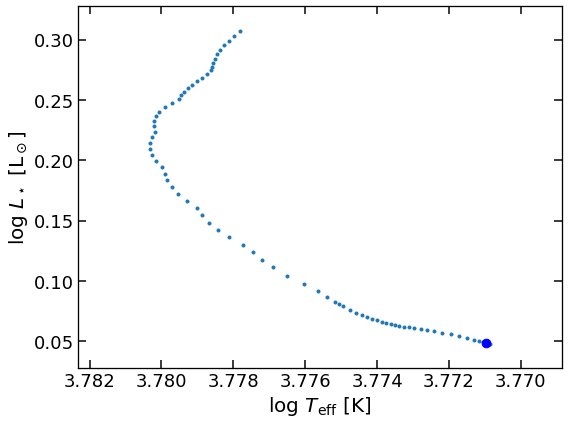

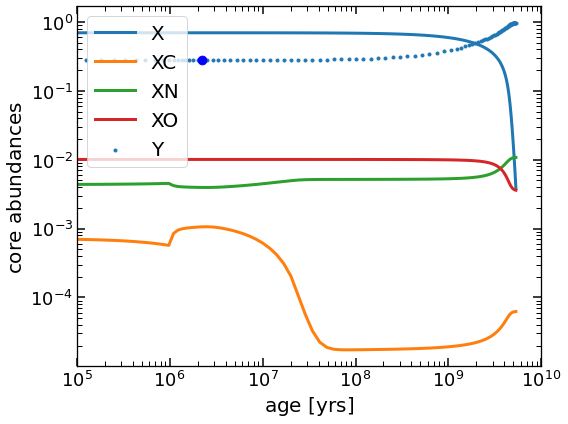

In [7]:
#=== track in HD-diagram ===
lTeff = data[:,6-1]
lLum  = data[:,4-1]
plt.figure(figsize=(8,6))
plt.scatter(lTeff,lLum,marker='.')
plt.scatter(lTeff[ipick],lLum[ipick],marker='.',color='blue',s=300)
plt.xlim(max(lTeff)+0.002,min(lTeff)-0.002)
plt.ylim(min(lLum)-0.02,max(lLum)+0.02)
plt.xlabel(r'$\log\ T_\mathrm{eff}\ \mathrm{[K]}$',fontsize=20)
plt.ylabel(r'$\log\ L_\star\ \mathrm{[L_\odot]}$',fontsize=20)
plt.tick_params(axis='both', labelsize=18)
plt.tick_params('both', length=8, width=1.5, which='major')
plt.tick_params('both', length=5, width=1, which='minor')
plt.tight_layout()
plt.show()

#=== He fraction in core ===
age = data[:,2-1]
Xc  = data[:,11-1]
Yc  = data[:,12-1]
XCc = data[:,13-1]
XNc = data[:,14-1]
XOc = data[:,15-1]
plt.figure(figsize=(8,6))
plt.xlim(1.E+5,10.E+9)
plt.xscale('log')
plt.yscale('log')
plt.plot(age,Xc,label='X')
plt.scatter(age,Yc,marker='.',label='Y')
plt.plot(age,XCc,label='XC')
plt.plot(age,XNc,label='XN')
plt.plot(age,XOc,label='XO')
plt.scatter(age[ipick],Yc[ipick],marker='.',color='blue',s=300)
plt.xlabel(r'$\mathrm{age}\ \mathrm{[yrs]}$',fontsize=20)
plt.ylabel(r'$\mathrm{core\ abundances}$',fontsize=20)
plt.tick_params(axis='both', labelsize=18)
plt.tick_params('both', length=8, width=1.5, which='major')
plt.tick_params('both', length=5, width=1, which='minor')
plt.legend(loc='upper left',fontsize=20)
plt.tight_layout()
plt.show()

In [8]:
#===================================================================
#1   Mr        Lagrangian mass coordinate (M\[Sun])
#2   r         Radius coordinate (R\[Sun])
#3   Lr        Luminosity (L\[Sun])
#4   P         Total pressure (N m-2)
#5   \[Rho]    Density (kg m-3)
#6   T         Temperature (K)
#7   U         Specific internal energy (J kg-1)
#8   S         Specific entropy (J K-1 kg-1)
#9   Cp        Specific heat at constant pressure (J K-1 kg-1)
#10  Gamma1    First adiabatic exponent
#11  \[Del]ad  Adiabatic temperature gradient
#12  \[Mu]     Mean molecular weight (see note below)
#13  ne        Electron number density (m-3)
#14  Pe        Electron pressure (N m-2)
#15  Pr        Radiation pressure (N m-2)
#16  \[Del]rad Radiative temperature gradient
#17  \[Del]    Material temperature gradient
#18  vc        Convective velocity (m s-1)
#19  \[Kappa]  Rosseland mean opacity (m2 kg-1)
#20  EpsNuc    Power per unit mass from all nuclear reactions, 
#              excluding neutrino losses (W kg-1)
#21  EpsPP     Power per unit mass from PP chain (W kg-1)
#22  EpsCNO    Power per unit mass from CNO cycle (W kg-1)
#23  Epsi3Alp  Power per unit mass from triple-alpha reaction (W kg-1)
#24  EpsNeu    Power loss per unit mass in nuclear neutrinos (W kg-1)
#25  Eps       Power loss per unit mass in non-nuclear neutrinos (W kg-1)
#26  EpsGrav   Power per unit mass from gravitational contraction (W kg-1)
#27  X         Hydrogen mass fraction (all ionization stages)
#28  XH2       Molecular hydrogen mass fraction
#29  X+        Singly-ionized hydrogen mass fraction
#30  Y         Helium mass fraction (all ionization stages)
#31  Y+        Singly-ionized helium mass fraction
#32  Y++       Doubly-ionized helium mass fraction
#33  XC        Carbon mass fraction
#34  XN        Nitrogren mass fraction
#35  XO        Oxygen mass fraction
#36  \[Psi]    Electron degeneracy parameter
#===================================================================

In [9]:
#================= read the structure file =========================
fname= 'structure_%5.5i.txt' %(ipick+1)
data = np.loadtxt(fname)
m    = np.array(data[:,1-1])
r    = np.array(data[:,2-1])
L    = np.array(data[:,3-1])
P    = np.array(data[:,4-1])
T    = np.array(data[:,6-1])
X    = np.array(data[:,27-1])
Y    = np.array(data[:,30-1])
XC   = np.array(data[:,33-1])
XN   = np.array(data[:,34-1])
XO   = np.array(data[:,35-1])
mu_Mod    = np.array(data[:,12-1])
rho_Mod   = np.array(data[:,5-1])
nablaAD   = np.array(data[:,11-1])
nablaRE   = np.array(data[:,16-1])
nabla_Mod = np.array(data[:,17-1])
kappa_Mod = np.array(data[:,19-1])
epsTOT    = np.array(data[:,20-1])+np.array(data[:,26-1])
eps_Mod   = np.array(data[:,20-1])
epsPP     = np.array(data[:,21-1])
epsCNO    = np.array(data[:,22-1])
epsGRAV   = np.array(data[:,26-1])

In [10]:
#====== check quality of fit formulae for material properties ======
Np = len(m)
nabla1 = np.zeros(Np)
nabla2 = np.zeros(Np)
nabla3 = np.zeros(Np)
eps1   = np.zeros(Np)
eps2   = np.zeros(Np)
eps3   = np.zeros(Np)
kap1   = np.zeros(Np)
kap2   = np.zeros(Np)
kap3   = np.zeros(Np)
kap4   = np.zeros(Np)
rhogas = np.zeros(Np)
mu1    = np.zeros(Np)
for i in range(0,Np):
    rhogas[i] = rho(P[i],T[i],X[i],Y[i])
    eps1[i]   = eps_pp(P[i],T[i],X[i],Y[i])
    eps2[i]   = eps_cno(P[i],T[i],X[i],Y[i],XC[i])
    eps3[i]   = eps(P[i],T[i],X[i],Y[i],XC[i])
    kap1[i]   = kappa_bf(P[i],T[i],X[i],Y[i])
    kap2[i]   = kappa_ff(P[i],T[i],X[i],Y[i])
    kap3[i]   = kappa_es(X[i])
    kap4[i]   = kappa(P[i],T[i],X[i],Y[i])
    nabla1[i] = nabla_RE(P[i],T[i],L[i]*Lsun,m[i]*Msun,X[i],Y[i])
    nabla2[i] = nabla_AD(P[i],T[i])
    nabla3[i] = nabla(P[i],T[i],L[i]*Lsun,m[i]*Msun,X[i],Y[i])
    mu1[i]    = mu(X[i],Y[i])
print("fit kappa:   %10.4e %10.4e" %(kappa_Mod[Np-1],kap4[Np-1]))
print("fit eps_PP:  %10.4e %10.4e" %(epsPP[Np-1],eps1[Np-1]))
print("fit eps_CNO: %10.4e %10.4e" %(epsCNO[Np-1],eps2[Np-1]))

fit kappa:   1.2857e-01 1.2614e-01
fit eps_PP:  1.8637e-03 1.9310e-03
fit eps_CNO: 8.7768e-04 1.1458e-03


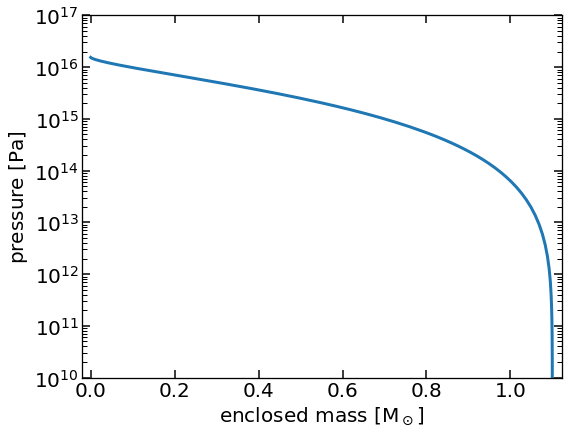

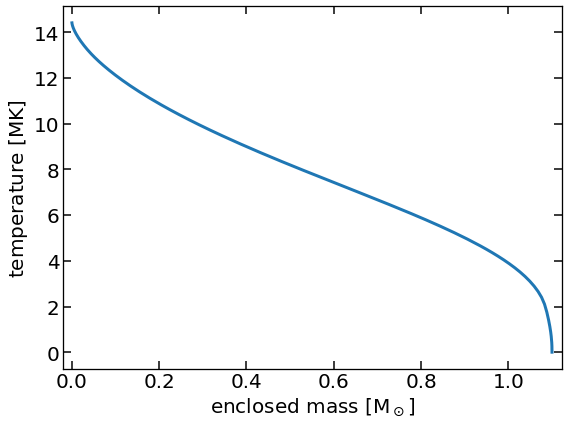

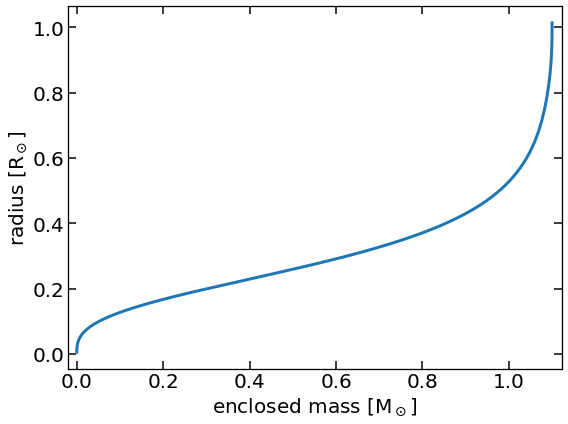

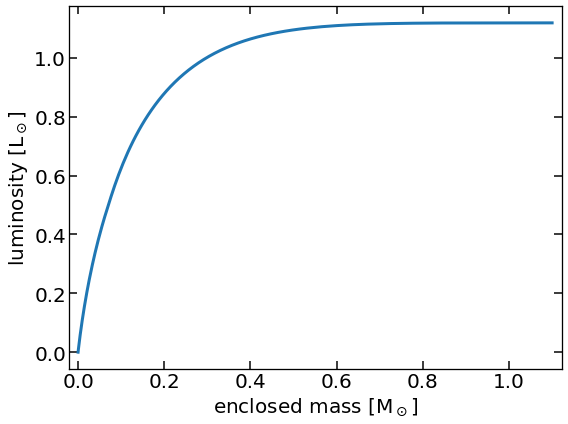

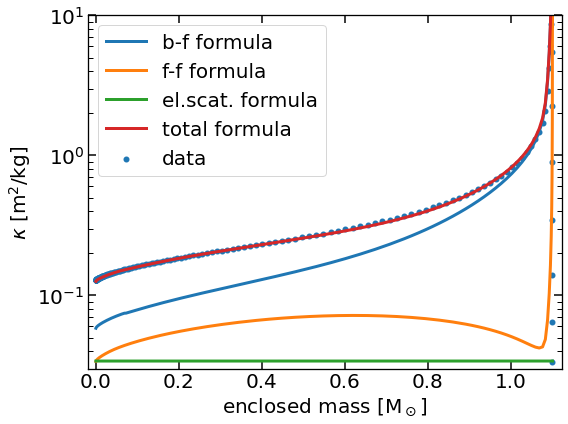

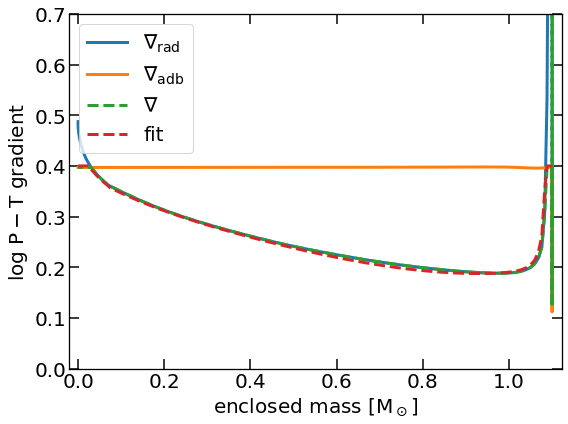

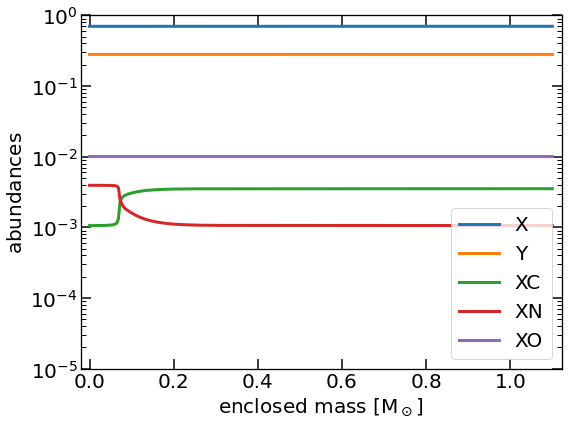

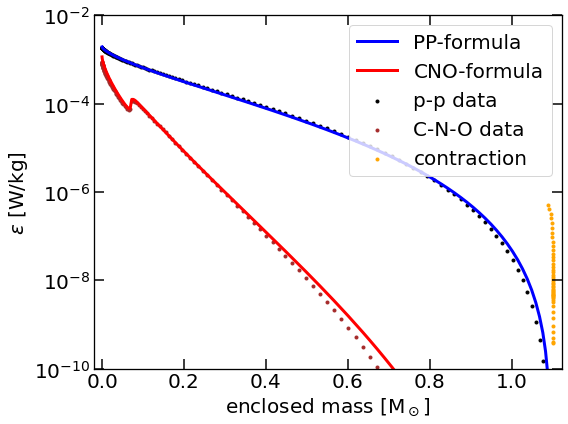

In [11]:
#===== plot the internal structure of the star =====
#===== add more plots if you are curious       =====
mp1 = -0.02
mp2 = np.max(m)*1.02
plt.figure(figsize=(8,6))
plt.plot(m,P,lw=3)
plt.yscale('log')
plt.xlim(xmin=mp1,xmax=mp2)
plt.ylim(1.E+10,1.E+17)
plt.xlabel(r'$\mathrm{enclosed\ mass}\ \mathrm{[M_\odot]}$',fontsize=20)
plt.ylabel(r'$\mathrm{pressure}\ \mathrm{[Pa]}$',fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.tick_params('both', length=8, width=1.5, which='major')
plt.tick_params('both', length=5, width=1, which='minor')
plt.tight_layout()
plt.show()
  
plt.figure(figsize=(8,6))
plt.plot(m,T/1.E+6,lw=3)
plt.xlim(xmin=mp1,xmax=mp2)
plt.xlabel(r'$\mathrm{enclosed\ mass}\ \mathrm{[M_\odot]}$',fontsize=20)
plt.ylabel(r'$\mathrm{temperature}\ \mathrm{[MK]}$',fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.tick_params('both', length=8, width=1.5, which='major')
plt.tick_params('both', length=5, width=1, which='minor')
plt.tight_layout()
plt.show()
  
plt.figure(figsize=(8,6))
plt.plot(m,r,lw=3)
plt.xlim(xmin=mp1,xmax=mp2)
plt.xlabel(r'$\mathrm{enclosed\ mass}\ \mathrm{[M_\odot]}$',fontsize=20)
plt.ylabel(r'$\mathrm{radius}\ \mathrm{[R_\odot]}$',fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.tick_params('both', length=8, width=1.5, which='major')
plt.tick_params('both', length=5, width=1, which='minor')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(m,L,lw=3)
plt.xlim(xmin=mp1,xmax=mp2)
plt.xlabel(r'$\mathrm{enclosed\ mass}\ \mathrm{[M_\odot]}$',fontsize=20)
plt.ylabel(r'$\mathrm{luminosity}\ \mathrm{[L_\odot]}$',fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.tick_params('both', length=8, width=1.5, which='major')
plt.tick_params('both', length=5, width=1, which='minor')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(m,kap1,lw=3,label='b-f formula')
plt.plot(m,kap2,lw=3,label='f-f formula')
plt.plot(m,kap3,lw=3,label='el.scat. formula')
plt.plot(m,kap4,lw=3,label='total formula')
plt.scatter(m,kappa_Mod,lw=3,label='data',marker='.')
plt.yscale('log')
plt.xlim(xmin=mp1,xmax=mp2)
plt.ylim(0.03,10)
plt.xlabel(r'$\mathrm{enclosed\ mass}\ \mathrm{[M_\odot]}$',fontsize=20)
plt.ylabel(r'$\kappa\ \mathrm{[m^2/kg]}$',fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.tick_params('both', length=8, width=1.5, which='major')
plt.tick_params('both', length=5, width=1, which='minor')
plt.legend(loc='upper left',fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(m,nablaRE,lw=3,label=r'$\nabla_\mathrm{rad}$')
plt.plot(m,nablaAD,lw=3,label=r'$\nabla_\mathrm{adb}$')
plt.plot(m,nabla_Mod,lw=3,label=r'$\nabla$',ls='--')
plt.plot(m,nabla3,lw=3,ls='--',label='fit')
plt.xlim(xmin=mp1,xmax=mp2)
plt.ylim(ymin=0.0,ymax=0.7)
plt.xlabel(r'$\mathrm{enclosed\ mass}\ \mathrm{[M_\odot]}$',fontsize=20)
plt.ylabel(r'$\mathrm{log\ P-T\ gradient}$',fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.tick_params('both', length=10, width=1.5, which='major')
plt.tick_params('both', length=5, width=1, which='minor')
plt.legend(loc='upper left',fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(m,X,lw=3,label='X')
plt.plot(m,Y,lw=3,label='Y')
plt.plot(m,XC,lw=3,label='XC')
plt.plot(m,XN,lw=3,label='XN')
plt.plot(m,XO,lw=3,label='XO')
plt.yscale('log')
plt.xlim(xmin=mp1,xmax=mp2)
plt.ylim(ymin=1.E-5,ymax=1.0)
plt.xlabel(r'$\mathrm{enclosed\ mass}\ \mathrm{[M_\odot]}$',fontsize=20)
plt.ylabel(r'$\mathrm{abundances}$',fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.tick_params('both', length=10, width=1.5, which='major')
plt.tick_params('both', length=5, width=1, which='minor')
plt.legend(loc='lower right',fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(m,eps1,lw=3,color='blue',label='PP-formula')
plt.plot(m,eps2,lw=3,color='red',label='CNO-formula')
plt.scatter(m,epsPP,color='black',marker='.',label='p-p data')
plt.scatter(m,epsCNO,color='brown',marker='.',label='C-N-O data')
plt.scatter(m,epsGRAV,color='orange',marker='.',label='contraction')
plt.yscale('log')
plt.xlim(xmin=mp1,xmax=mp2)
plt.ylim(ymin=1.E-10,ymax=1.E-2)
plt.xlabel(r'$\mathrm{enclosed\ mass}\ \mathrm{[M_\odot]}$',fontsize=20)
plt.ylabel(r'$\epsilon\ \mathrm{[W/kg]}$',fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.tick_params('both', length=10, width=1.5, which='major')
plt.tick_params('both', length=5, width=1, which='minor')
plt.legend(loc='upper right',fontsize=20)
plt.tight_layout()
plt.show()
